# EigenImages with PCA (Principal Component Analysis)
**EigenImages:** is a special technique of extracting features using PCA.

In [86]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from glob import glob
from PIL import Image
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC     # Support vector Classifier is also known as Maximum Margin Classifier.
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [3]:
# Load numpy zip values created in Module 2.
data = np.load('data_100_100_norm.npz')

In [4]:
X = data['arr_0']    # independent features.
y = data['arr_1']    # target features

X.shape, y.shape

((5461, 10000), (5461,))

# Eigen Image:
**Steps:**

1. Subtract all the rows with the mean
2. Apply PCA to this data. (Note: PCA uses EigenValues(Variance) and EigenVectors(Direction) and all these values come from the co-variance matrix)
    Note: Larger the variance, larger the information available in that feature.

    *PCA intuition:* Identify features with larger variance
3. After initializing PCA, we need to select which Eigenvalues are important, and we have to use those eigenvalues.


In [5]:
# Step 1
X1 = X - X.mean(axis=0) 


In [6]:
from sklearn.decomposition import PCA

In [7]:
# Since we don't know # components, we will put None for now. (We can use elbow method to compute this)
pca = PCA(n_components=None, whiten=True, svd_solver='auto')

In [8]:
x_pca = pca.fit_transform(X1)

In [11]:
x_pca.shape
# svd_solver will reduce the # components from 10000 to row size.

(5461, 5461)

**Now Extracting important features from PCA:**
1. Explained_variance is the eigenvalues.
2. Explained_variance_ratio is the ratio of explained variance in %

Extract this from PCA and calculate cumulative sum.

In [12]:
eigenRatio = pca.explained_variance_ratio_
eigenRatioCum = np.cumsum(eigenRatio)

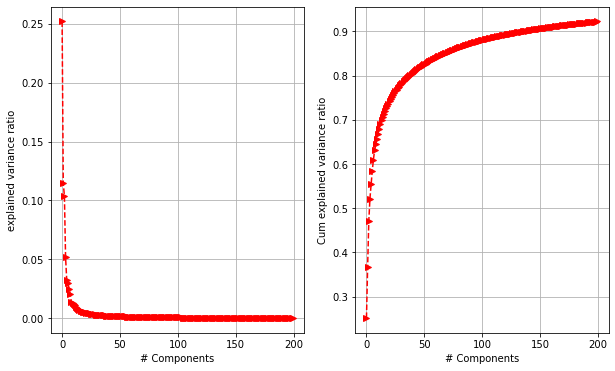

In [22]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(eigenRatio[:200], 'r>--')
plt.xlabel("# Components")
plt.ylabel("explained variance ratio")
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(eigenRatioCum[:200], 'r>--')
plt.xlabel("# Components")
plt.ylabel("Cum explained variance ratio")
plt.grid(True)
# Vizualize only 200 components from start.

# Dimensionality reduction using elbow graph and PCA
**Elbow Graph explained above:**
The above graphs are same, that explains the eigenvalues for each component. (200 of them here)
1. In the first graph:
    Eg. The 1st point/component has an explained_variance_ratio of 25%, 2nd has of 12%, 3rd has 10% and so on.
    
**NOTE:** By reading the 2nd graph, we can see that if we consider almost 50 components, those 50 components explains almost 82% of the data. 
So instead of considering 10k components, we can select these 50 components and still cover ~80% of the information. Discard the other.

*Conclusion:* Using elbow method, consider # of components between 25-30 with an explained variance of 70-75%.
But in order to get min of 80% variance, we are considering 50 components.

Now apply PCA again with n_components=50

**NOTE:** If we use PCA to reduce the dimensions, such images are called **EIGEN-IMAGES**

In [23]:
pca_50 = PCA(n_components=50, whiten=True, svd_solver='auto')
x_pca_50 = pca_50.fit_transform(X1)

In [25]:
x_pca_50.shape
# We have successfully reduced the dimensions using PCA.

(5461, 50)

In [26]:
# Save this PCA.
pickle.dump(pca_50, open('pca_50.pickle', 'wb'))

# Now analyse these 50 components and create the eigen images.
1. Consider 50 components and inverse transform them. (pca.inverse_transform(X))
2. 

In [28]:
# Step 1: inverse transform
x_pca_inv = pca_50.inverse_transform(x_pca_50)
x_pca_inv.shape

# We are again getting 10k directions.

(5461, 10000)

This is the eigen image with 50 components


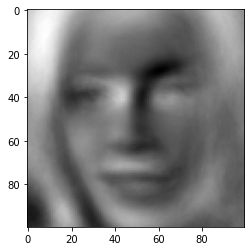

In [30]:
# Consider 1 image, i.e. 1 row.
eigen_image = x_pca_inv[0,:]   #0th column and all rows.

eigen_image = eigen_image.reshape((100, 100))
plt.imshow(eigen_image, cmap='gray')

print("This is the eigen image with 50 components")

# Show random images with their eigen images:

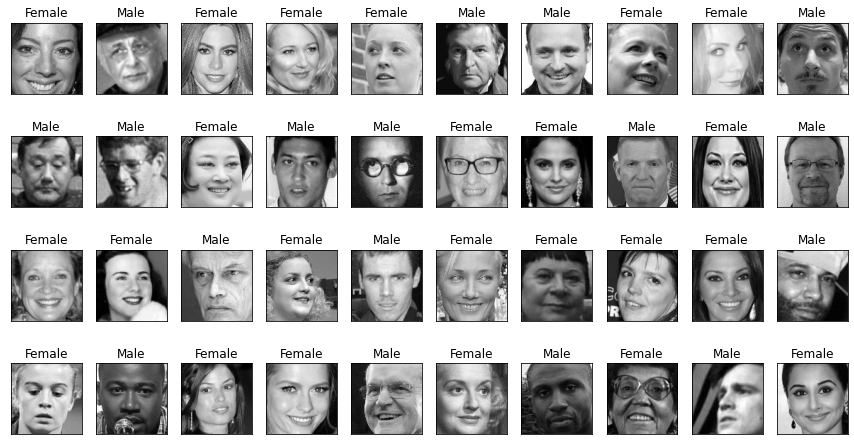

====================Eigen Images====================


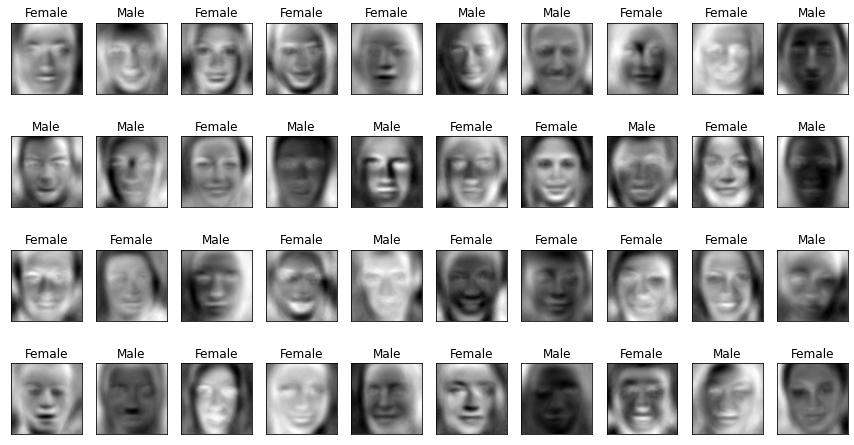

In [31]:
def label(y):
    if y==0:
        return 'Male'
    else:
        return 'Female'

# Randomly pick their indices.
np.random.randint(1001)
pics = np.random.randint(0, 5451, 40)

plt.figure(figsize=(15, 8))

# Randomly select the picture and display it.
for i, pic in enumerate(pics):
    plt.subplot(4, 10, i+1)
    img = X[pic:pic+1].reshape(100, 100)
    plt.imshow(img, cmap='gray')
    plt.title('{}'.format(label(y[pic])))
    plt.xticks([])
    plt.yticks([])
plt.show()

print("="*20+'Eigen Images'+"="*20)

plt.figure(figsize=(15, 8))

# Randomly select the eigen-image and display it.
for i, pic in enumerate(pics):
    plt.subplot(4, 10, i+1)
    img = x_pca_inv[pic:pic+1].reshape(100, 100)
    plt.imshow(img, cmap='gray')
    plt.title('{}'.format(label(y[pic])))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [33]:
# Save the array in numpy zip.

np.savez('data_pca_50_y_mean.pickle',x_pca_50, y, X.mean())

 # Training ML Model using SVM:

In [36]:
data = np.load('data_pca_50_y_mean.pickle.npz')
data.files
# Here arr0 is the X, arr1 is target variable y, and arr_2 is the mean of the data.

['arr_0', 'arr_1', 'arr_2']

In [40]:
X = data['arr_0']
y = data['arr_1']
mean = data['arr_2']

# Split the data into training and testing.
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.2, stratify=y)
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((4368, 50), (1093, 50), (4368,), (1093,))

In [49]:
model = SVC(C=1.0, kernel='rbf', gamma=0.01)
model.fit(Xtr, ytr)

print('Model Trained Successfully..')

Model Trained Successfully..


In [48]:
# Score for training and test data.
print("Training Score: ", model.score(Xtr, ytr))
print("Test Score: ", model.score(Xts, yts))

Training Score:  0.8644688644688645
Test Score:  0.7795059469350412


# Model Evaluation and Hyper Parameter tuning.
**Note:** We cannot directly select the model. We need to evaluate it using different techniques like:
1. Confusion Matrix
2. Classification Report: Recall, Precision, Accuracy.
3. Kappa Score.
4. ROC and AUC. (Probability.) 

**Note:** SVM does not give probability. we can set probability=True.

In [50]:
model = SVC(C=1.0, kernel='rbf', gamma=0.01, probability=True)
model.fit(Xtr, ytr)

print('Model Trained Successfully..')

Model Trained Successfully..


**1. Confusion Matrix:**

In [53]:
y_pred = model.predict(Xts)
y_prob = model.predict_proba(Xts)    # Probability

In [62]:
cm = metrics.confusion_matrix(yts, y_pred)

cm

array([[313, 129],
       [112, 539]], dtype=int64)

# How to read confusion matrix? 
Suppose indexing of the matrix starts from 0,0

1. value: 442 is the total number of male samples. 
   - out of which model was able to predict 313 correctly, 
   - and 129 incorrectly.
2. Value 651 is the total number of female samples.
   - out of which the model was able to predict 112 incorrectly.
   - and 539 samples are incorrectly classfied.
3. 1093 samples were of test data.

In [63]:
# Print the sum of the columns in the last row.
cm = np.concatenate((cm, cm.sum(axis=0).reshape(1, -1)), axis=0)
cm = np.concatenate((cm, cm.sum(axis=1).reshape(-1, 1)), axis=1)
cm

array([[ 313,  129,  442],
       [ 112,  539,  651],
       [ 425,  668, 1093]], dtype=int64)

**To Check if the model is bias or not.**

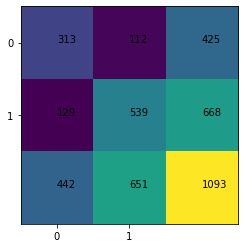

In [69]:
# check bias.
plt.imshow(cm)
for i in range(3):
    for j in range(3):
        plt.text(i, j, cm[i, j])
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.show()

In [70]:
# Recall and precision score for male:
recall = 313/425
precision = 313/442
print("Recall score for male: ", recall)
print("Precision score for male: ", precision)
print("These things we can get in classification report.")

Recall score for male:  0.7364705882352941
Precision score for male:  0.7081447963800905


# Classification Report:

In [71]:
cr = metrics.classification_report(yts, y_pred, target_names=['male', 'female'], output_dict=True) 
#Output of above is a dictionary because of last parameter. This is also easy to convert in pandas data frame.

pd.DataFrame(cr).T

,precision,recall,f1-score,support
male,0.736471,0.708145,0.722030,442.000000
female,0.806886,0.827957,0.817286,651.000000
accuracy,0.779506,0.779506,0.779506,0.779506
macro avg,0.771678,0.768051,0.769658,1093.000000
weighted avg,0.778411,0.779506,0.778765,1093.000000


# Kappa Score
1. Usually for a good model, Kappa score is more than ~60%
   - This is what we use to decide if we should use this model or not.
2. If kappa score is less than 40%, it is a poor model.
3. More than 80%, it is a really good model.

In [73]:
kappa = metrics.cohen_kappa_score(yts, y_pred)
kappa

0.5394322042344268

# ROC (Receiving Operator Characterics) and AUC (Area Under the Curve)
**Note:** If AUC score is more than 80%, it is a good model.

Text(0.5, 1.0, 'ROC')

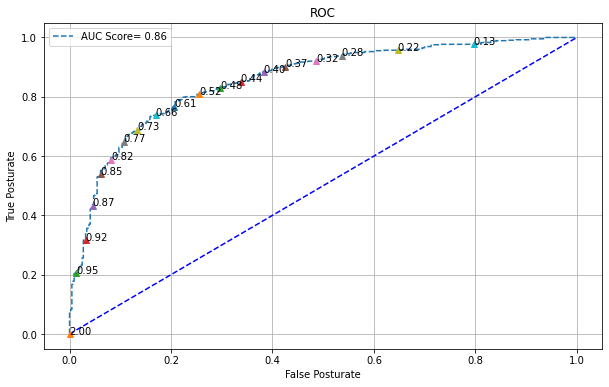

In [84]:
fpr, tpr, thresh = metrics.roc_curve(yts, y_prob[:, 1])   # 1 indicates ROC for female, 0 is for male.
# Fpr: False Posturates, Tpr: True Posturates, thresh: Threshold Values.

auc_score = metrics.auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, '--')           # ROC Line
plt.plot([0, 1], [0, 1], 'b--')    # Base Line

for i in range(0, len(thresh), 20):
    plt.plot(fpr[i], tpr[i], "^")
    plt.text(fpr[i], tpr[i], "%0.2f"%thresh[i])

plt.legend(['AUC Score= %0.2f'%auc_score])
plt.grid(True)
plt.xlabel("False Posturate")
plt.ylabel("True Posturate")
plt.title("ROC")


**Conclusion:** Based on Kappa Score and AUC Score, we can say that this is a substantially good model.
 - but we can still improve the model by hyper parameter tuning.


# Hyper Parameter Tuning of our Machine Learning Model.
 - Using Grid Search Method.

In [85]:
model_tune = SVC()

In [88]:
param_grid = {'C':[1, 10, 20, 30, 50, 100],
             'kernel':['rbf', 'poly'],
             'gamma':[0.1, 0.05, 0.01, 0.001, 0.002, 0.005],
             'coef0':[0, 1]
             }     

# Creating dictionary of all the hyper parameters with possible values.

In [90]:
model_grid = GridSearchCV(model_tune, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)

# model_tune = model which we want to tune.
# param_grid = which hyper parameters we want to tune.
# Scoring = Which scores we want? Can be found in metrics.SCORERS
# cv = # of Cross Validations to perform.

In [91]:
model_grid.fit(X, y)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed: 44.2min finished


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10, 20, 30, 50, 100], 'coef0': [0, 1],
                         'gamma': [0.1, 0.05, 0.01, 0.001, 0.002, 0.005],
                         'kernel': ['rbf', 'poly']},
             scoring='accuracy', verbose=1)

In [94]:
best_index = model_grid.best_index_
best_params = model_grid.best_params_
best_score = model_grid.best_score_
print("Best index: ", best_index)
print("Best params: ", best_params)
print("Best score: ", best_score)

Best index:  17
Best params:  {'C': 1, 'coef0': 1, 'gamma': 0.01, 'kernel': 'poly'}
Best score:  0.786303114390946


In [105]:
# With the best parameters, build the best Machine learning model.
model_best = SVC(C=1, kernel='poly', gamma=0.01, coef0=1, probability=True)
model_best.fit(Xtr, ytr)

SVC(C=1, coef0=1, gamma=0.01, kernel='poly', probability=True)

In [106]:
model_best.score(Xts, yts)

0.7950594693504117

In [107]:
y_pred = model_best.predict(Xts)
y_prob = model_best.predict_proba(Xts)    # Probability

cm = metrics.confusion_matrix(yts, y_pred)

cm

array([[321, 121],
       [103, 548]], dtype=int64)

In [108]:
# Print the sum of the columns in the last row.
cm = np.concatenate((cm, cm.sum(axis=0).reshape(1, -1)), axis=0)
cm = np.concatenate((cm, cm.sum(axis=1).reshape(-1, 1)), axis=1)
cm

array([[ 321,  121,  442],
       [ 103,  548,  651],
       [ 424,  669, 1093]], dtype=int64)

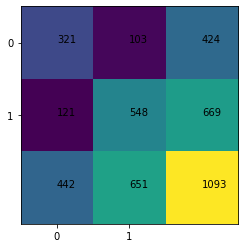

In [109]:
# check bias.
plt.imshow(cm)
for i in range(3):
    for j in range(3):
        plt.text(i, j, cm[i, j])
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.show()

In [110]:
cr = metrics.classification_report(yts, y_pred, target_names=['male', 'female'], output_dict=True) 
#Output of above is a dictionary because of last parameter. This is also easy to convert in pandas data frame.

pd.DataFrame(cr).T

,precision,recall,f1-score,support
male,0.757075,0.726244,0.741339,442.000000
female,0.819133,0.841782,0.830303,651.000000
accuracy,0.795059,0.795059,0.795059,0.795059
macro avg,0.788104,0.784013,0.785821,1093.000000
weighted avg,0.794037,0.795059,0.794327,1093.000000


In [111]:
kappa = metrics.cohen_kappa_score(yts, y_pred)
kappa

0.5717638992377414

Text(0.5, 1.0, 'ROC')

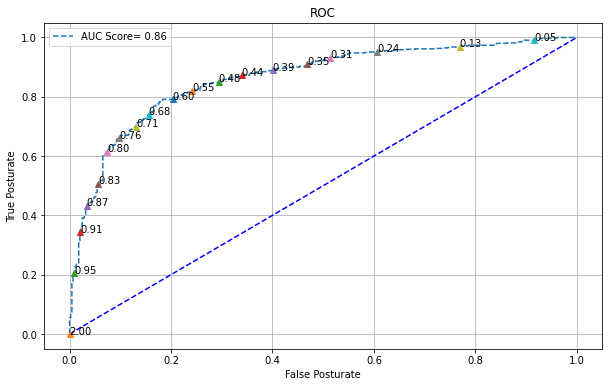

In [112]:
fpr, tpr, thresh = metrics.roc_curve(yts, y_prob[:, 1])   # 1 indicates ROC for female, 0 is for male.
# Fpr: False Posturates, Tpr: True Posturates, thresh: Threshold Values.

auc_score = metrics.auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, '--')           # ROC Line
plt.plot([0, 1], [0, 1], 'b--')    # Base Line

for i in range(0, len(thresh), 20):
    plt.plot(fpr[i], tpr[i], "^")
    plt.text(fpr[i], tpr[i], "%0.2f"%thresh[i])

plt.legend(['AUC Score= %0.2f'%auc_score])
plt.grid(True)
plt.xlabel("False Posturate")
plt.ylabel("True Posturate")
plt.title("ROC")


# Save Model in Pickle

In [115]:
pickle.dump(model_best, open('model_svm_ideal.pickle', 'wb'))
pickle.dump(mean, open('mean_pre_processing.pickle', 'wb'))